# Convolutional Neural Network Pneumonia Classification

In [35]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [36]:
DATASET_PATH = './parkinson_xray/parkinson_xray'
IMAGE_SIZE = (64, 264)

### a. Resize dan Augmentasi data (augmentasi data ada dibagian setelah splitting untuk fitnya dan penggunaanya ada di bagian training model)

In [37]:
image_list = []
label_list = []

for idx, dir in enumerate(os.listdir(DATASET_PATH)):
    for file in os.listdir(os.path.join(DATASET_PATH, dir)):
        img_path = os.path.join(os.path.join(DATASET_PATH, dir, file))
        img = load_img(img_path, target_size=IMAGE_SIZE, color_mode='grayscale')
        img_array = img_to_array(img)
        image_list.append(img_array)
        label_list.append(idx)

Resize gambar langsung saat load dan ubah ke grayscale untuk mengurangi jumlah channel menjadi satu. Tujuannya agar lebih menghemat memori, mengingat bahwa gambar X-ray tidak memerlukan informasi warna

In [38]:
image_array = np.array(image_list, dtype='float32')
image_array /= 255.0

label_array = np.array(label_list)

print(image_array.shape)
print(label_array.shape)

(5216, 64, 264, 1)
(5216,)


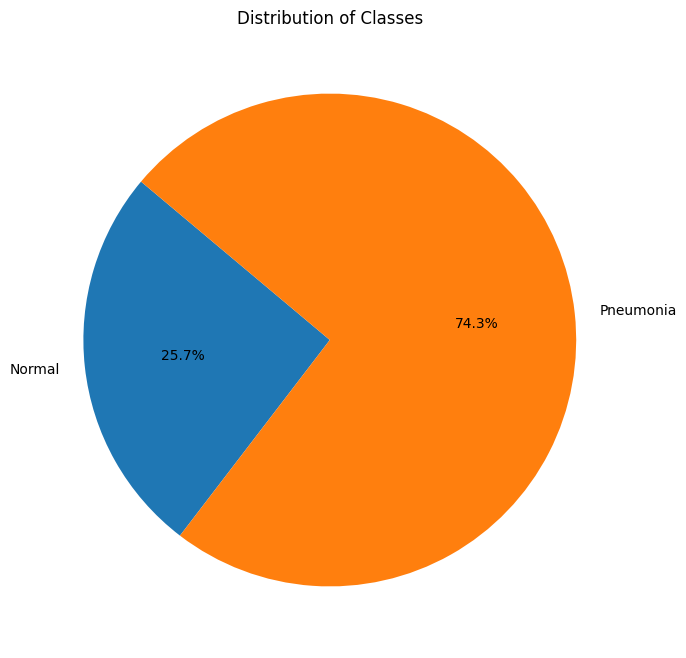

In [39]:
unique_classes, counts = np.unique(label_array, return_counts=True)

plt.figure(figsize=(8, 8))
plt.pie(counts, labels=['Normal', 'Pneumonia'], autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Classes')
plt.show()

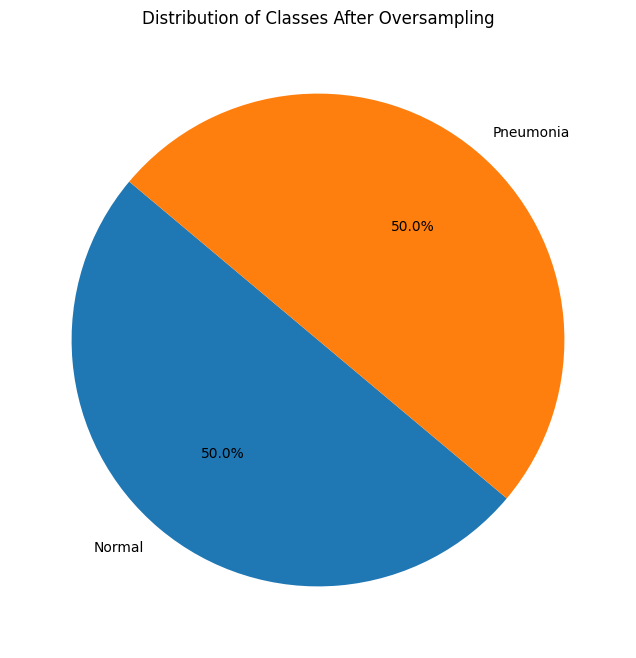

In [40]:
oversampler = RandomOverSampler(random_state=42)

image_array_reshaped = image_array.reshape(len(image_array), -1)

image_array_resampled, label_array_resampled = oversampler.fit_resample(image_array_reshaped, label_array)

image_array = image_array_resampled.reshape(-1, IMAGE_SIZE[0], IMAGE_SIZE[1], 1)
label_array = label_array_resampled

unique_classes, counts = np.unique(label_array, return_counts=True)

plt.figure(figsize=(8, 8))
plt.pie(counts, labels=['Normal', 'Pneumonia'], autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Classes After Oversampling')
plt.show()

melakukan oversampling agar distribusinya merata

Gambar: (7750, 64, 264, 1), Label: (7750,)


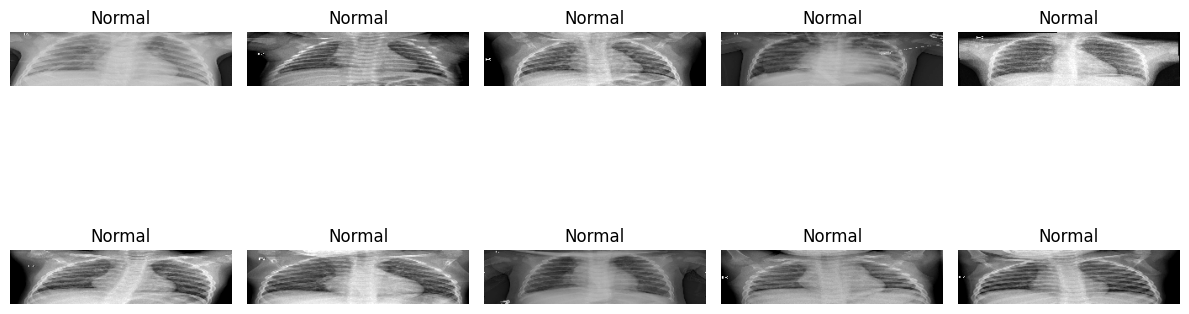

In [41]:
print(f"Gambar: {image_array.shape}, Label: {label_array.shape}")

random_indices = random.sample(range(len(image_array)), 10)

plt.figure(figsize=(12, 6))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(image_array[idx].squeeze(), cmap='gray')
    plt.axis('off')
    label = 'Normal' if np.argmax(label_array[idx]) == 0 else 'Pneumonia'
    plt.title(label)

plt.tight_layout()
plt.show()

### b. Splitting dataset

In [42]:
# Split dataset menjadi training, validation, dan test set (70:20:10)
X_train, X_temp, y_train, y_temp = train_test_split(image_array, label_array, test_size=0.3, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42, shuffle=True)

total_samples = len(image_array)
train_percent = len(X_train) / total_samples * 100
val_percent = len(X_val) / total_samples * 100
test_percent = len(X_test) / total_samples * 100

print("Train set:", X_train.shape, y_train.shape, f"({train_percent:.2f}%)")
print("Validation set:", X_val.shape, y_val.shape, f"({val_percent:.2f}%)")
print("Test set:", X_test.shape, y_test.shape, f"({test_percent:.2f}%)")

Train set: (5425, 64, 264, 1) (5425,) (70.00%)
Validation set: (1550, 64, 264, 1) (1550,) (20.00%)
Test set: (775, 64, 264, 1) (775,) (10.00%)


In [43]:
# Bikin data generator
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

datagen.fit(X_train)

### c. Arsitektur model sesuai gambar soal

In [44]:
# Define model
model = Sequential()
model.add(Conv2D(6, (5, 5), activation='relu', padding='same', input_shape=X_train[0].shape))
model.add(AveragePooling2D(pool_size=(2, 2), strides=2))
model.add(Conv2D(16, (5, 5), activation='relu', padding='same'))
model.add(AveragePooling2D(pool_size=(2, 2), strides=2))
model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dense(84, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/home/kelvin/.conda/envs/tf-gpu2/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 64, 264, 6)     │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_4             │ (None, 32, 132, 6)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 132, 16)    │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_5             │ (None, 16, 66, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 16896)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 120)            │     2,027,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │           850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,041,237 (7.79 MB)

 Trainable params: 2,041,237 (7.79 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
# Training model dengan data augmentation dengan batchsize 32 selama 5 epoch
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    steps_per_epoch=len(X_train) // 32,
    epochs=5
)

Epoch 1/5


/home/kelvin/.conda/envs/tf-gpu2/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


169/169 ━━━━━━━━━━━━━━━━━━━━ 22s 97ms/step - accuracy: 0.6285 - loss: 0.6185 - val_accuracy: 0.9019 - val_loss: 0.2775
Epoch 2/5
  1/169 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8438 - loss: 0.3450

2024-11-08 10:00:32.771903: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3678768644076634701
/home/kelvin/.conda/envs/tf-gpu2/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-11-08 10:00:32.772031: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10055481311614150888


169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8438 - loss: 0.3450 - val_accuracy: 0.9006 - val_loss: 0.2817
Epoch 3/5
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.8514 - loss: 0.3715 - val_accuracy: 0.8832 - val_loss: 0.2895
Epoch 4/5
  1/169 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9375 - loss: 0.2933

2024-11-08 10:00:42.958744: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3678768644076634701
2024-11-08 10:00:42.958853: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10055481311614150888


169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9375 - loss: 0.2933 - val_accuracy: 0.9006 - val_loss: 0.2509
Epoch 5/5
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.8389 - loss: 0.3728 - val_accuracy: 0.9013 - val_loss: 0.2571


### d. Grafik train loss dan val loss

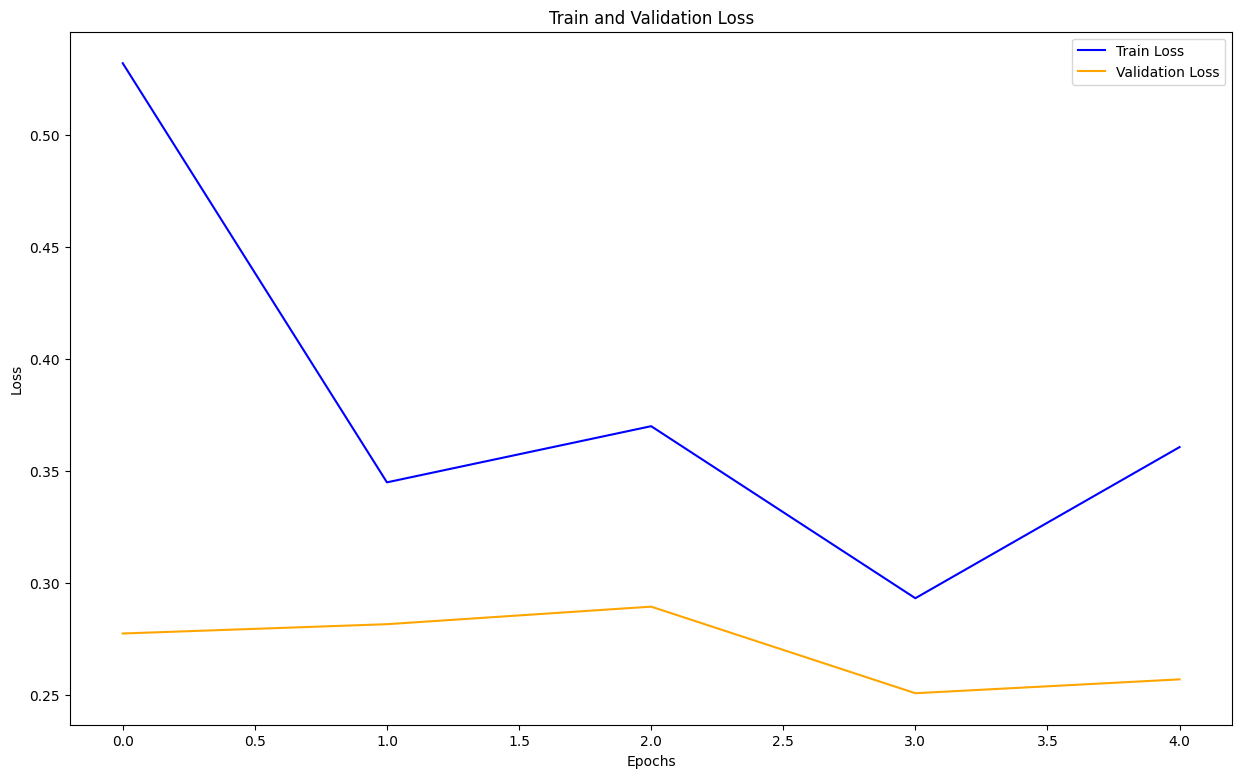

In [46]:
plt.figure(figsize=(15, 9))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Berdasarkan grafik plot loss di atas, model menunjukkan performa yang cukup baik dan dapat dikategorikan sebagai just-right model. Grafik tidak menunjukkan adanya tanda-tanda overfitting, namun ada sedikit indikasi underfitting pada data training. Meskipun demikian, hasil evaluasi pada test dataset menunjukkan akurasi yang tinggi dan nilai loss yang rendah. Hal ini menandakan bahwa model mampu melakukan generalisasi dengan baik pada data yang belum pernah dilihat sebelumnya, sehingga tetap dapat dianggap sebagai just-right model.

### e. Evaluate

In [47]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8866 - loss: 0.2913
Test Loss: 0.2851318418979645
Test Accuracy: 0.892903208732605


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


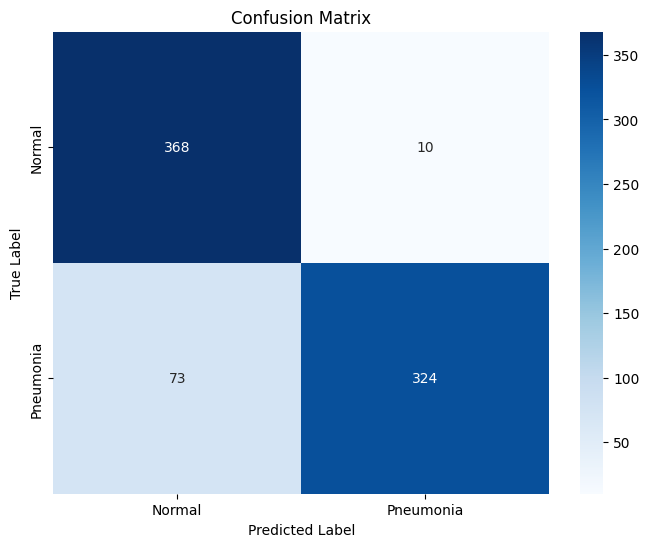

              precision    recall  f1-score   support

           0       0.83      0.97      0.90       378
           1       0.97      0.82      0.89       397

    accuracy                           0.89       775
   macro avg       0.90      0.89      0.89       775
weighted avg       0.90      0.89      0.89       775



In [48]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

y_pred = y_pred.reshape(-1)
y_test_labels = y_test.reshape(-1)

cm = confusion_matrix(y_test_labels, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_test_labels, y_pred))

Hasil evaluasi menunjukkan bahwa model memiliki performa dan kemampuan generalisasi yang cukup baik. Namun, berdasarkan confusion matrix, terlihat bahwa model masih perlu ditingkatkan dalam mendeteksi kelas Pneumonia. Hal ini ditunjukkan oleh jumlah kesalahan klasifikasi yang cukup signifikan, khususnya kasus Pneumonia yang salah diklasifikasikan sebagai Normal